
# Walmart Weekly Sales Forecasting

**Objective: To develop a statistical Model to predict store sales using historical markdown data available. The historical sales data for 45 Walmart stores located in different regions to predicting the Weekly sales for each store. Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays.**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_summary(x):
    return pd.Series([x.count(), x.isna().sum(), x.isna().sum()*100/x.isna().count(), x.nunique(), 
                      x.sum(), x.mean(), x.median(), x.std(), 
                      x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.1), x.quantile(0.25), x.quantile(0.5), 
                      x.quantile(0.75), x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
            index = ['N', 'NMISS', '% NMISS', 'UNIQUES', 'SUM', 'MEAN', 'MEDIAN', 'STD', 
                     'MIN', 'P1','P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_summary(x):
    Mode = x.value_counts().sort_values(ascending = False).reset_index()[0:1]
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [5]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = False)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Data Importing & Merging of Datasets to get the final output

In [6]:
# Writing output data into excel
output = pd.ExcelWriter('walmart_sales_output.xlsx')

In [7]:
# Load the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

In [8]:
# Mergeing Datasets
train = train.merge(stores, how='left').merge(features, how='left')
test = test.merge(stores, how='left').merge(features, how='left')

In [9]:
# Combining train and test data
train['Split'] = 'Train'
test['Split'] = 'Test'
df = pd.concat([train, test], ignore_index=True)

In [10]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Split
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Train
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,Train
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,Train
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,Train
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,Train


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536634 entries, 0 to 536633
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         536634 non-null  int64  
 1   Dept          536634 non-null  int64  
 2   Date          536634 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     536634 non-null  bool   
 5   Type          536634 non-null  object 
 6   Size          536634 non-null  int64  
 7   Temperature   536634 non-null  float64
 8   Fuel_Price    536634 non-null  float64
 9   MarkDown1     265596 non-null  float64
 10  MarkDown2     197685 non-null  float64
 11  MarkDown3     242326 non-null  float64
 12  MarkDown4     237143 non-null  float64
 13  MarkDown5     266496 non-null  float64
 14  CPI           498472 non-null  float64
 15  Unemployment  498472 non-null  float64
 16  Split         536634 non-null  object 
dtypes: bool(1), float64(10), int64(3), object(3)
mem

### EDA

In [12]:
# Converting True & False in 'Isholday' column to int i.e 1 and 0
df['IsHoliday'] = df['IsHoliday'].astype('int64')

In [13]:
# Changed the Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
# Dummy variables: Dates
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week

In [15]:
df.select_dtypes(include=np.number).apply(continuous_summary).T.round(1)

,N,NMISS,% NMISS,UNIQUES,SUM,MEAN,MEDIAN,STD,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,536634.0,0.0,0.0,45.0,1.191790e+07,22.2,22.0,12.8,1.0,1.0,3.0,5.0,11.0,22.0,33.0,40.0,43.0,45.0,45.0
Dept,536634.0,0.0,0.0,81.0,2.376070e+07,44.3,37.0,30.5,1.0,1.0,4.0,7.0,18.0,37.0,74.0,92.0,95.0,98.0,99.0
Weekly_Sales,421570.0,115064.0,21.4,359464.0,6.737219e+09,15981.3,7612.0,22711.2,-4988.9,5.0,60.0,291.1,2079.6,7612.0,20205.9,42845.7,61202.0,106479.6,693099.4
IsHoliday,536634.0,0.0,0.0,2.0,3.858900e+04,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Size,536634.0,0.0,0.0,40.0,7.334636e+10,136678.6,140167.0,61007.7,34875.0,34875.0,39690.0,39910.0,93638.0,140167.0,202505.0,204184.0,206302.0,219622.0,219622.0
Temperature,536634.0,0.0,0.0,4178.0,3.153893e+07,58.8,60.1,18.7,-7.3,16.9,26.5,32.8,45.2,60.1,73.2,82.8,86.8,92.4,102.0
Fuel_Price,536634.0,0.0,0.0,1011.0,1.829015e+06,3.4,3.5,0.4,2.5,2.6,2.7,2.8,3.0,3.5,3.7,3.9,4.0,4.2,4.5
MarkDown1,265596.0,271038.0,50.5,4023.0,1.975504e+09,7438.0,5126.5,9411.3,-2781.4,18.2,164.0,403.3,2114.6,5126.5,9303.8,15308.1,22494.6,53311.9,103185.0
MarkDown2,197685.0,338949.0,63.2,2715.0,6.937310e+08,3509.3,385.3,8992.0,-265.8,0.0,3.0,10.8,72.5,385.3,2392.4,8762.3,18632.1,47382.7,104519.5
MarkDown3,242326.0,294308.0,54.8,2885.0,4.502208e+08,1857.9,40.8,11616.1,-179.3,0.1,0.8,2.0,7.2,40.8,174.3,573.9,1330.5,76741.0,149483.3


In [16]:
df.select_dtypes(include=['object', 'bool']).apply(categorical_summary)

,Type,Split
N,536634,536634
NMISS,0,0
MODE,A,Train
FREQ,274191,421570
PERCENT,51.09,78.56


## Visualisation

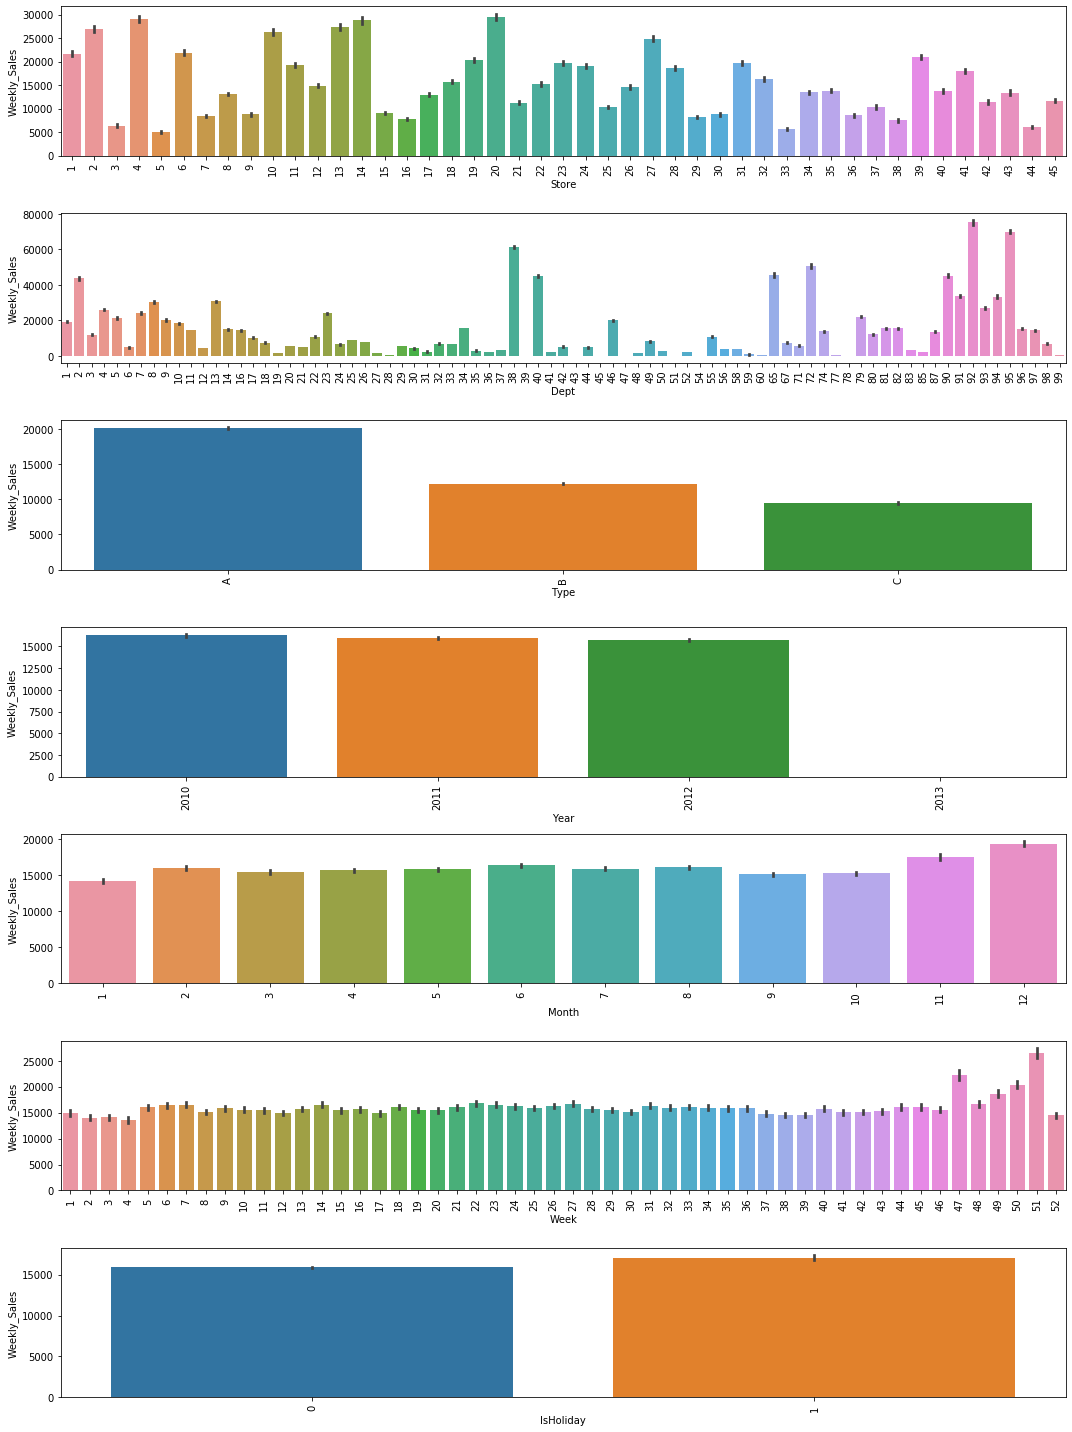

In [17]:
# Visualizing Weekly Sales across different categorical features
plt_cols = ['Store','Dept','Type','Year','Month','Week','IsHoliday'] 

plt.figure(figsize = (15,20))
for i, col in enumerate(plt_cols):
    plt.subplot(7, 1, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = df[col], y = df.Weekly_Sales)
    plt.xticks(rotation = 90)
    plt.tight_layout()

#### Analysing the Graph
- Store 20 is showing highest weekly sales.
- Deparment 92 has the highest weekly sales.
- Store Type A has the highest weekly sales.
- In Year 2010, the weekly sales was high
- During the month of november and december, the weekly sales has increased.
- weekly sale is high in week 47 and 51.
- During the holidays the sales are high.

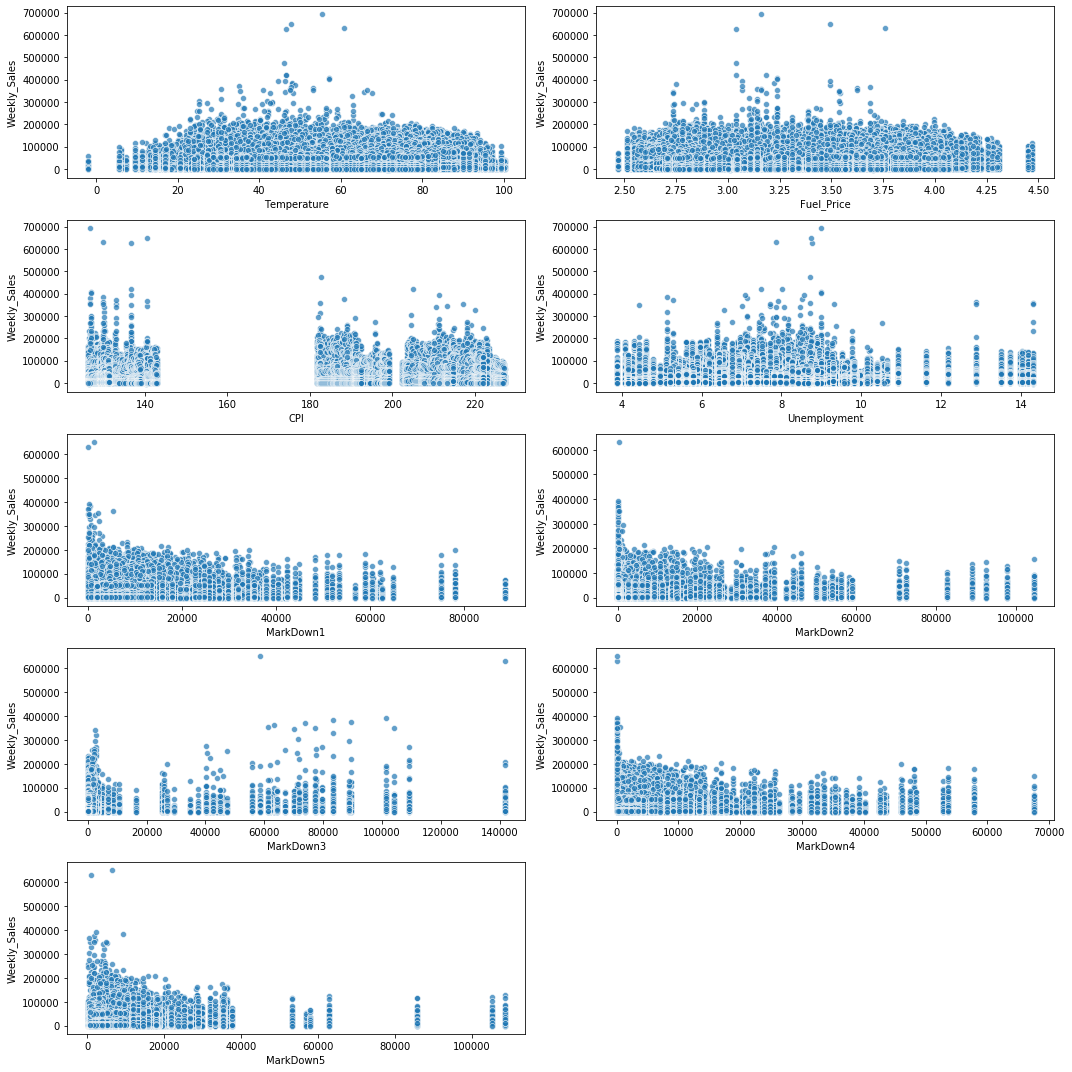

In [18]:
# Visualizing Weekly Sales across different continuous features
plt_cols = ['Temperature','Fuel_Price','CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

plt.figure(figsize = (15,15))
for i, col in enumerate(plt_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.scatterplot(x = df[col], y = df.Weekly_Sales, alpha=0.70)
    plt.tight_layout() 

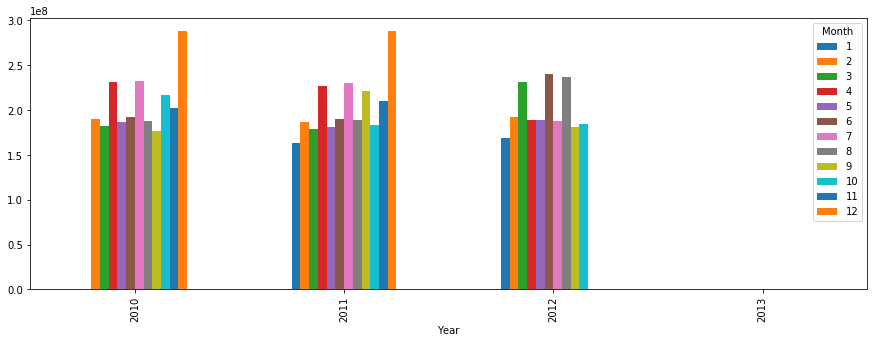

In [19]:
pd.pivot_table(data = df, index = df.Year, columns= df.Month, 
                values='Weekly_Sales', aggfunc='sum').plot(kind='bar', figsize=(15,5))
plt.show()

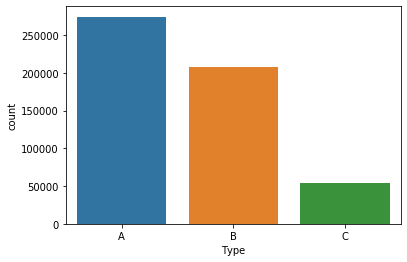

In [20]:
# Numbers of type observation
sns.countplot(df.Type)
plt.show()

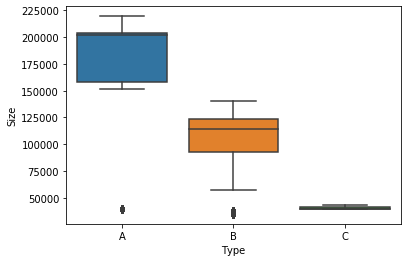

In [21]:
# Size vs Type
sns.boxplot(df.Type,df.Size)
plt.show()

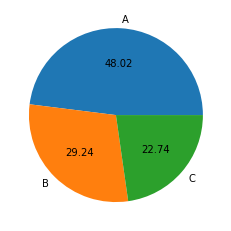

In [22]:
# Mean Weekly Sales by Type
plt.pie(df.groupby('Type').Weekly_Sales.mean(), labels=df.Type.unique(), autopct='%.2f')
plt.show()

**By boxplot and piechart, The median of A is the highest and C is the lowest i.e stores with more sizes have higher sales.
There is no overlapped area in size among A, B, and C.**

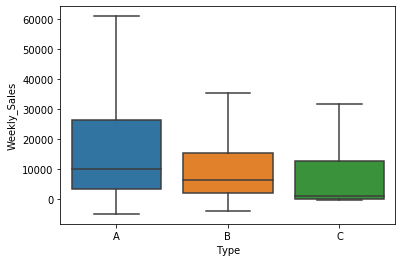

In [23]:
# Weekly Sales by Type
sns.boxplot(df.Type, df.Weekly_Sales, showfliers=False)
plt.show()

**The median of A is the highest and C is the lowest. That means stores with more sizes have higher sales record (The order of median of size and median of sales is the same)**

### Outlier Treatment 

In [24]:
# Getting Categorical and continuous variables
# Date is not included
categorical = ['Store','Dept','IsHoliday','Type','Year','Month','Week']
continuous = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size','MarkDown1','MarkDown2','MarkDown3',
              'MarkDown4','MarkDown5']

In [25]:
df[continuous] = df[continuous].apply(lambda x: x.clip(lower = x.dropna().quantile(0.01),
                                                       upper = x.dropna().quantile(0.99)))

### Missing Values Treatment 

In [26]:
# percentage of missing value
df.loc[:, df.isna().sum()>0].isna().sum()*100/df.shape[0]

Weekly_Sales    21.441802
MarkDown1       50.507049
MarkDown2       63.162043
MarkDown3       54.843338
MarkDown4       55.809173
MarkDown5       50.339337
CPI              7.111365
Unemployment     7.111365
dtype: float64

#### Imputing with store dept level

In [27]:
# Treating Missing values in CPI and Unemployment with mean by Store and Department wise
df['CPI'] = df.groupby(['Store','Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()) 
                                                          if x.mean()>0 else x.fillna(df.CPI.mean()))

df['Unemployment'] = df.groupby(['Store','Dept'])['Unemployment'].transform(lambda x: 
                                                       x.fillna(x.mean()) if x.mean()>0 else x.fillna(df.Unemployment.mean()))

In [28]:
# Imputing negative values in MarkDown's as missing if any
markdown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
df[markdown] = df[markdown].where(df[markdown]>0,0)
df[markdown] = df[markdown].fillna(0)

In [29]:
# percentage of missing value
df.loc[:,df.columns.difference(['Weekly_Sales'])].isna().sum()

CPI             0
Date            0
Dept            0
Fuel_Price      0
IsHoliday       0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
Month           0
Size            0
Split           0
Store           0
Temperature     0
Type            0
Unemployment    0
Week            0
Year            0
dtype: int64

### Adding new Holidays

In [30]:
# Making New Holiday by getting dates of 'Super_Bowl','Labour_Day','Thanksgiving','Christmas'
new_holidays = ['2010-02-12','2011-02-11','2012-02-10','2013-02-08',#Super_Bowl
                '2010-09-10','2011-09-09','2012-09-07','2013-09-06',#Labour_Day
                '2010-11-26','2011-11-25','2012-11-23','2013-11-29',#Thanksgiving
                '2010-12-31','2011-12-30','2012-12-28','2013-12-27']#Christmas

In [31]:
# Adding new holidays to dataset
df.loc[df.Date.isin(new_holidays), 'IsHoliday'] = 1

### Dummy variables: Categorical Data

In [32]:
# Converting Categorical Variable 'Type' into ordinal Variable 
type_mapping = {"A": 3, "B": 2, "C": 1}
df['Type'] = df['Type'].map(type_mapping)

### Log Transformation

In [33]:
# Log Transformation of MarkDown
markdown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for col in markdown:
    df[col] = df[col].apply(lambda x: np.log(x+1))

### Creating Dependent Y column

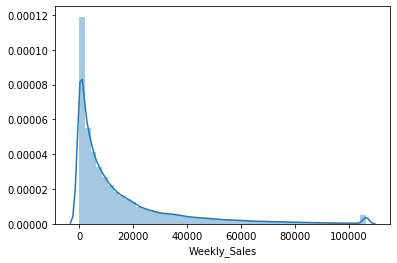

In [34]:
sns.distplot(df.loc[df.Split == 'Train','Weekly_Sales'])
plt.show()

* Deviation from Normal Distribution (Positive Skewness)

In [35]:
print("Skewness of Weekly_Sales is: ", df.loc[df.Split == 'Train','Weekly_Sales'].skew())

Skewness of Weekly_Sales is:  2.2004167042847156


**Log Transformation: -**

In [36]:
df.loc[df.Split == 'Train','Weekly_Sales'].min()

5.0

In [37]:
df.loc[df.Split == 'Train','ln_Weekly_Sales'] = np.log(df.loc[df.Split == 'Train','Weekly_Sales'])

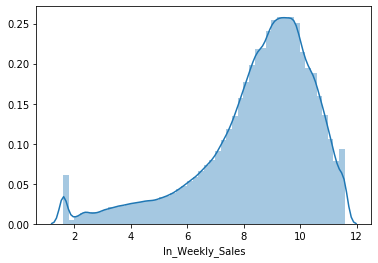

In [38]:
sns.distplot(df.loc[df.Split == 'Train','ln_Weekly_Sales'])
plt.show()

In [39]:
print("Skewness of Weekly_Sales is: ", df.loc[df.Split == 'Train','ln_Weekly_Sales'].skew())

Skewness of Weekly_Sales is:  -1.2118352624018651


### Seprating dataset

In [40]:
train = df.loc[df.Split == 'Train',:]
test = df.loc[df.Split == 'Test',:]

In [41]:
train.drop('Split', axis=1, inplace=True)
test.drop('Split', axis=1, inplace=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [43]:
train.to_excel(output,'train', index=False)
test.to_excel(output,'test', index=False)

In [44]:
traindate = train.Date.copy()
testdate = test.Date.copy()

train.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True,)

In [45]:
train.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,ln_Weekly_Sales
0,1,1,24924.50,0,3,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,10.123607
1,1,1,46039.49,1,3,151315,38.51,2.572,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,6,10.737255


In [46]:
test.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,ln_Weekly_Sales
0,1,1,NaN,0,3,151315,55.32,3.386,8.819878,8.546500,3.947776,8.199986,7.915136,223.462779,6.573,2012,11,44,NaN
1,1,1,NaN,0,3,151315,61.24,3.314,9.343325,8.123229,3.720378,8.444147,8.725046,223.481307,6.573,2012,11,45,NaN


### EDA

In [47]:
continuous = ['ln_Weekly_Sales', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 
              'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
categorical = ['Store', 'Dept', 'IsHoliday', 'Type', 'Week']

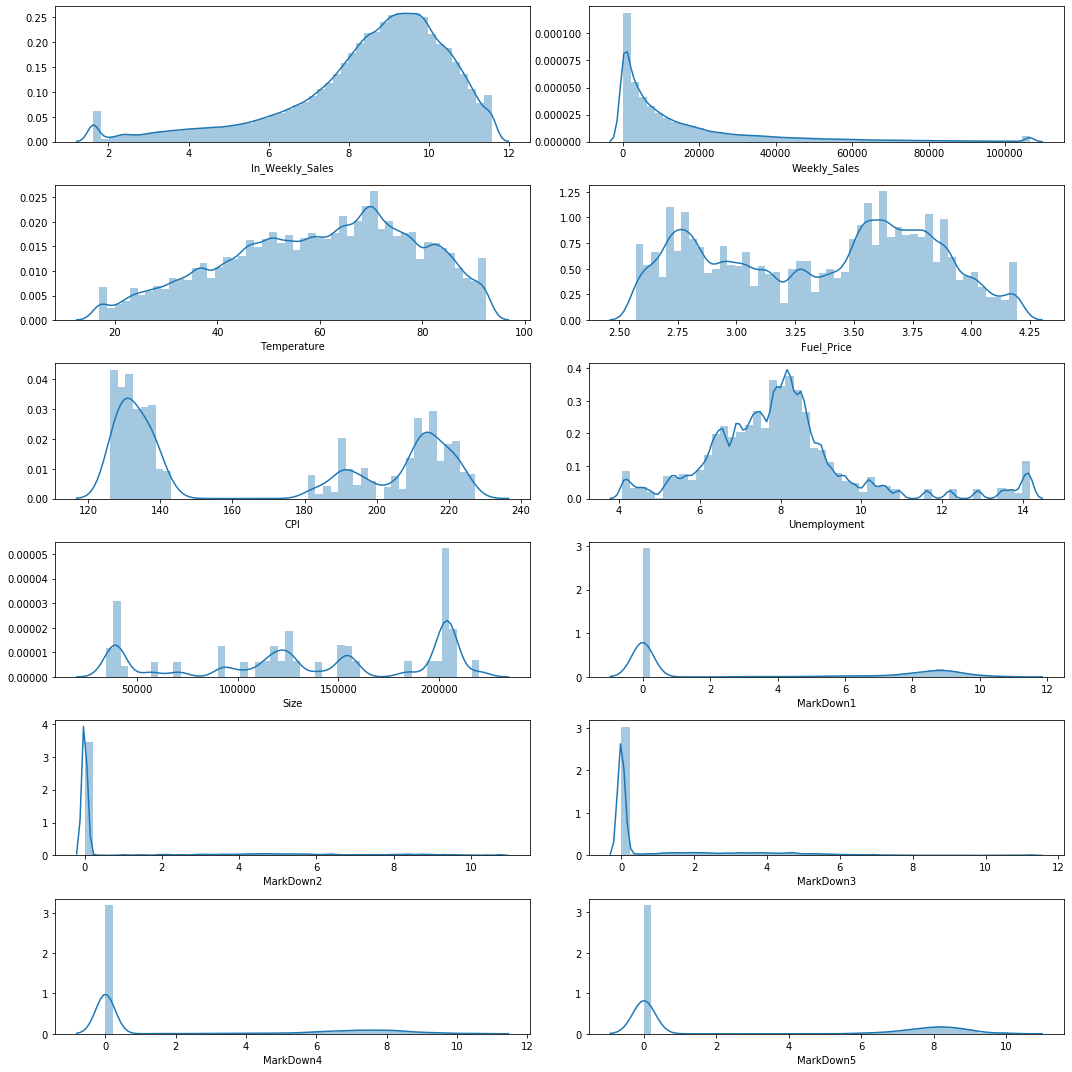

In [48]:
plt.figure(figsize = (15,15))
for i, col in enumerate(continuous):
    plt.subplot(6, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.distplot(train[col])
    plt.tight_layout() 

In [49]:
train[continuous].apply(continuous_summary).T.round(1)

,N,NMISS,% NMISS,UNIQUES,SUM,MEAN,MEDIAN,STD,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
ln_Weekly_Sales,421570.0,0.0,0.0,354230.0,3.585261e+06,8.5,8.9,2.0,1.6,1.6,4.1,5.7,7.6,8.9,9.9,10.7,11.0,11.6,11.6
Weekly_Sales,421570.0,0.0,0.0,354230.0,6.599483e+09,15654.5,7612.0,20781.7,5.0,5.0,60.0,291.1,2079.6,7612.0,20205.9,42845.7,61202.0,106477.7,106479.6
Temperature,421570.0,0.0,0.0,3436.0,2.533285e+07,60.1,62.1,18.3,16.9,18.3,27.3,34.0,46.7,62.1,74.3,83.6,87.3,92.4,92.4
Fuel_Price,421570.0,0.0,0.0,861.0,1.416574e+06,3.4,3.5,0.5,2.6,2.6,2.7,2.7,2.9,3.5,3.7,3.9,4.0,4.2,4.2
CPI,421570.0,0.0,0.0,2138.0,7.217371e+07,171.2,182.3,39.2,126.1,126.1,126.5,128.8,132.0,182.3,212.4,219.4,221.9,225.5,227.2
Unemployment,421570.0,0.0,0.0,347.0,3.355525e+06,8.0,7.9,1.9,4.1,4.2,5.3,6.0,6.9,7.9,8.6,9.8,12.2,14.2,14.2
Size,421570.0,0.0,0.0,40.0,5.764039e+10,136727.9,140167.0,60980.6,34875.0,34875.0,39690.0,39910.0,93638.0,140167.0,202505.0,204184.0,206302.0,219622.0,219622.0
MarkDown1,421570.0,0.0,0.0,2238.0,1.233207e+06,2.9,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,7.9,9.1,9.4,10.2,10.9
MarkDown2,421570.0,0.0,0.0,1464.0,6.100357e+05,1.4,0.0,2.8,0.0,0.0,0.0,0.0,0.0,0.0,1.2,6.1,8.2,10.0,10.8
MarkDown3,421570.0,0.0,0.0,1643.0,4.700637e+05,1.1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7,4.3,5.4,7.6,11.2


In [50]:
train[categorical].apply(categorical_summary)

,Store,Dept,IsHoliday,Type,Week
N,421570.00,421570.00,421570.00,421570.00,421570.00
NMISS,0.00,0.00,0.00,0.00,0.00
MODE,13.00,1.00,0.00,3.00,7.00
FREQ,10474.00,6435.00,391909.00,215478.00,8929.00
PERCENT,2.48,1.53,92.96,51.11,2.12


### Correlation Matrix

In [51]:
correlation = train.corr()
correlation.to_excel(output, 'correlation')

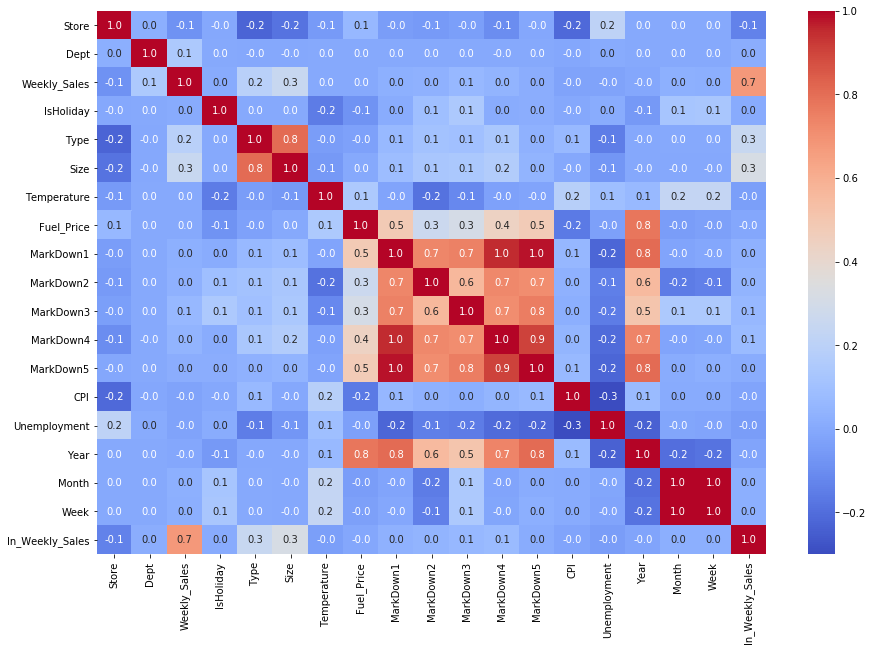

In [52]:
# Plotting correlation between all important features
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt=".1f")
plt.show()

In [53]:
# Dropping highly correlated features
features_drop = ['MarkDown1', 'Year'] 
train.drop(features_drop, axis=1, inplace=True)

# Feature Engineering

In [54]:
train.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Week,ln_Weekly_Sales
0,1,1,24924.50,0,3,151315,42.31,2.572,0.0,0.0,0.0,0.0,211.096358,8.106,2,5,10.123607
1,1,1,46039.49,1,3,151315,38.51,2.572,0.0,0.0,0.0,0.0,211.242170,8.106,2,6,10.737255


## Variance Inflation Factor (VIF)

#### VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [55]:
model_param = 'ln_Weekly_Sales ~ ' + ' + '.join(train.columns.difference(['ln_Weekly_Sales','Weekly_Sales']))
print(model_param)

ln_Weekly_Sales ~ CPI + Dept + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + Month + Size + Store + Temperature + Type + Unemployment + Week


In [58]:
# High VIF means information in that variable has already been explained by other X variables present in the model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# dropped: Month + MarkDown5 + 
model_param = '''ln_Weekly_Sales ~ CPI + Dept + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + 
Size + Store + Temperature + Type + Unemployment + Week'''

y, X = dmatrices(model_param, data = train, return_type = 'dataframe')

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values('VIF', ascending=False, inplace=True, ignore_index=True)
vif.head()

,Features,VIF
0,Intercept,175.304285
1,MarkDown4,3.540521
2,Type,3.062416
3,Size,3.022742
4,MarkDown2,2.377880


In [59]:
# All the features have less than 4 VIF Factor(low Multicollinearity). using these features for model building.
vif_cols = list(set(vif.Features).difference(['Intercept']))
vif_cols.sort()
print('numbers of selected features: ', len(vif_cols))
print(vif_cols)

numbers of selected features:  13
['CPI', 'Dept', 'Fuel_Price', 'IsHoliday', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'Size', 'Store', 'Temperature', 'Type', 'Unemployment', 'Week']


### Linear reggresion

In [60]:
formula_m1 = 'ln_Weekly_Sales ~ ' + ' + '.join(vif_cols)
print(formula_m1)

ln_Weekly_Sales ~ CPI + Dept + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + Size + Store + Temperature + Type + Unemployment + Week


In [61]:
import statsmodels.formula.api as smf

# dropped: 
formula_m1 = '''ln_Weekly_Sales ~ CPI + Dept + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + 
Size + Store + Temperature + Type + Unemployment + Week'''

model1 = smf.ols(formula_m1, data=train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:        ln_Weekly_Sales   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3963.
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:59:56   Log-Likelihood:            -8.7555e+05
No. Observations:              421570   AIC:                         1.751e+06
Df Residuals:                  421556   BIC:                         1.751e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.1745      0.039    207.613   

**Analysis of Residuals**

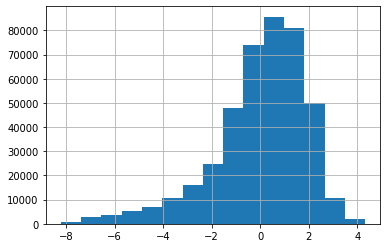

In [62]:
# Checking Errors distribution
model1.resid.hist(bins=15)
plt.show()
# Residuals following Normal distribution. This is one of the Assumption in Linear Regression.

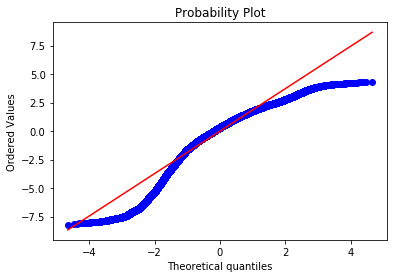

In [63]:
# Q-Q plot of Residuals
from scipy import stats
import pylab
stats.probplot(model1.resid, dist='norm', plot=pylab)
pylab.show()

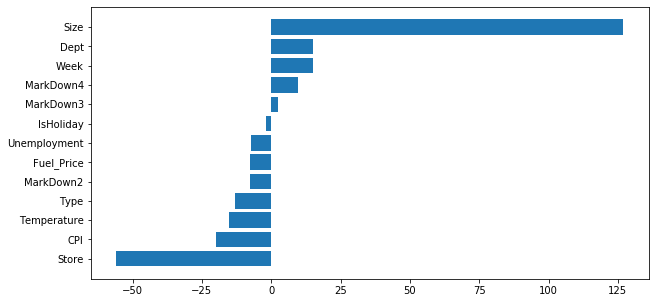

In [67]:
# Getting importance of factors
lr_fi = pd.DataFrame({'Features' : model1.tvalues[1:].index,
                      'T_value' : model1.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)

lr_fi.to_excel(output, 'Drivers', startrow=2, startcol=0, index = False)

plt.figure(figsize=(10,5))
plt.barh(width = lr_fi.T_value, y = lr_fi.Features)
plt.show()

# Machine learning

#### Getting Train and Test dataset for Machine Learning modelling

In [68]:
# Getting final features
final_selected = model1.pvalues.index.difference(['Intercept'])
print('final features : ',final_selected)
X = train[final_selected]
Y = train.ln_Weekly_Sales

final features :  Index(['CPI', 'Dept', 'Fuel_Price', 'IsHoliday', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'Size', 'Store', 'Temperature', 'Type', 'Unemployment',
       'Week'],
      dtype='object')


In [69]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [70]:
# dataframe for train and test output
train_output = pd.DataFrame()
test_output = pd.DataFrame()

# Including the Y(dependent) Variable to compare
train_output['Weekly_Sales'] = np.exp(train_y)
test_output['Weekly_Sales'] = np.exp(test_y)

# MODELS

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn import svm

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report, mean_squared_error, mean_absolute_error, log_loss)

In [72]:
# Different models
models = []
models.append(('LR', LinearRegression()))
models.append(('LGBMR', LGBMRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('ETR', ExtraTreeRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('XGBR', XGBRFRegressor()))

In [73]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, n_jobs=-1) 
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.107833 (0.003397)
LGBMR: 0.891285 (0.000427)
CART: 0.951503 (0.001044)
ETR: 0.938008 (0.004236)
GBR: 0.658282 (0.010373)
XGBR: 0.502359 (0.002511)


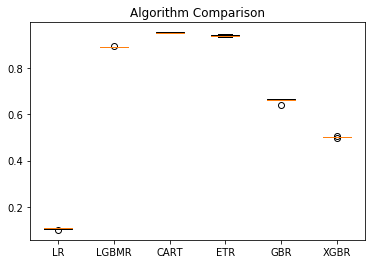

In [74]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [78]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True, ignore_index=True)
models_df

,Model,Score
0,CART,95.1503
1,ETR,93.8008
2,LGBMR,89.1285
3,GBR,65.8282
4,XGBR,50.2359
5,LR,10.7833


#### DecisionTreeRegressor shows good Score

## Decision Trees 

In [117]:
# Model building
param = {'max_depth': [20,25,30], 
         'min_samples_split' : range(2,30,5),
         'min_samples_leaf': range(2,10,2)
         }

gscv_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                        param_grid=param, 
                        cv = 5,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 25.2min finished


In [118]:
gscv_dt.best_params_

{'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 22}

In [119]:
# best Score
-1*gscv_dt.best_score_

0.16487490016064096

**Building final descision  tree model on best parameters**

In [120]:
dt = gscv_dt.best_estimator_

# Predicting values for both training and testing data sets
train_output.loc[:, 'dt_pred'] = np.exp(dt.predict(train_x))
test_output.loc[:, 'dt_pred'] = np.exp(dt.predict(test_x))

In [121]:
# Metrics for both training and testing data 

# R-square Score
dt_r2_train = metrics.r2_score(train_y, train_output.dt_pred)
dt_r2_test = metrics.r2_score(test_y, test_output.dt_pred)
print('Training R-square: ', dt_r2_train ,' | ','Testing R-square: ', dt_r2_test)

# Mean Squared Error - MSE
dt_MSE_train = metrics.mean_squared_error(train_y, train_output.dt_pred)
dt_MSE_test = metrics.mean_squared_error(test_y, test_output.dt_pred)
print('Training MSE:', dt_MSE_train,' | ','Testing MSE:', dt_MSE_test)

# Root Mean Squared Error - RMSE
dt_RMSE_train = np.sqrt(dt_MSE_train)
dt_RMSE_test = np.sqrt(dt_MSE_test)
print('Training RMSE: ',dt_RMSE_train,' | ','Testing RMSE:',dt_RMSE_test)

# Root Mean Squared Percentage Error - RMSPE
dt_RMSPE_train = np.sqrt(np.mean(((train_y - train_output['dt_pred'])/train_y)**2))
dt_RMSPE_test = np.sqrt(np.mean(((test_y - test_output['dt_pred'])/test_y)**2))
print('Training RMSPE:', dt_RMSPE_train,' | ','Testing RMSPE:', dt_RMSPE_test)

# Mean Absolute Error - MAE
dt_MAE_train = metrics.mean_absolute_error(train_y, train_output.dt_pred)
dt_MAE_test = metrics.mean_absolute_error(test_y, test_output.dt_pred)
print('Training MAE:', dt_MAE_train, '|', 'Testing MAE:', dt_MAE_test)

# Mean Absolute Percentage Error - MAPE
dt_MAPE_train = np.mean(np.abs(train_y - train_output['dt_pred'])/train_y)
dt_MAPE_test = np.mean(np.abs(test_y - test_output['dt_pred'])/test_y)                   
print('Training MAPE:', dt_MAPE_train, '|', 'Testing MAPE:',dt_MAPE_test)

Training R-square:  -158672156.4848534  |  Testing R-square:  -157734008.96199286
Training MSE: 663271553.8729883  |  Testing MSE: 661138505.7874624
Training RMSE:  25754.05897859575  |  Testing RMSE: 25712.61374865384
Training RMSPE: 2372.882749989001  |  Testing RMSPE: 2370.7003564885604
Training MAE: 15539.121213216637 | Testing MAE: 15490.999661249303
Training MAPE: 1518.782307741891 | Testing MAPE: 1515.327080372701


**Decile Analysis**

In [122]:
# Creating Deciles
train_output.loc[:,'dt_deciles'] = pd.qcut(train_output['dt_pred'], 10, labels = False, duplicates = 'drop')
test_output.loc[:,'dt_deciles'] = pd.qcut(test_output['dt_pred'], 10, labels = False, duplicates = 'drop')

# Decile Analysis for train_output data
dt_decile_train = train_output.groupby('dt_deciles')[['Weekly_Sales', 'dt_pred']].mean().reset_index().sort_values(
    by = 'dt_deciles', ascending = False)

# Decile Analysis for test_output data
dt_decile_test = test_output.groupby('dt_deciles')[['Weekly_Sales', 'dt_pred']].mean().reset_index().sort_values(
    by = 'dt_deciles', ascending = False)

# write the data into the file
dt_decile_train.to_excel(output, 'Decile', startrow=3 , startcol=0, index = False)
dt_decile_test.to_excel(output, 'Decile', startrow=3 , startcol=5, index = False)

In [123]:
dt_decile_train

,dt_deciles,Weekly_Sales,dt_pred
9,9,66594.766040,66310.137765
8,8,33012.314266,32787.809730
7,7,20524.298241,20355.658336
6,6,13866.128648,13742.748800
5,5,9411.264034,9315.343895
4,4,6254.910937,6175.699703
3,3,3933.986005,3868.622516
2,2,2147.180377,2089.036105
1,1,799.376608,756.346343
0,0,103.693111,85.849970


In [124]:
dt_decile_test

,dt_deciles,Weekly_Sales,dt_pred
9,9,66340.513777,66334.721065
8,8,32840.726987,32606.483081
7,7,20487.960436,20222.640000
6,6,13889.050864,13684.702344
5,5,9470.273623,9294.090878
4,4,6249.922806,6128.258999
3,3,3935.668014,3825.799637
2,2,2166.861243,2072.498476
1,1,839.121275,750.286785
0,0,122.217714,85.992683


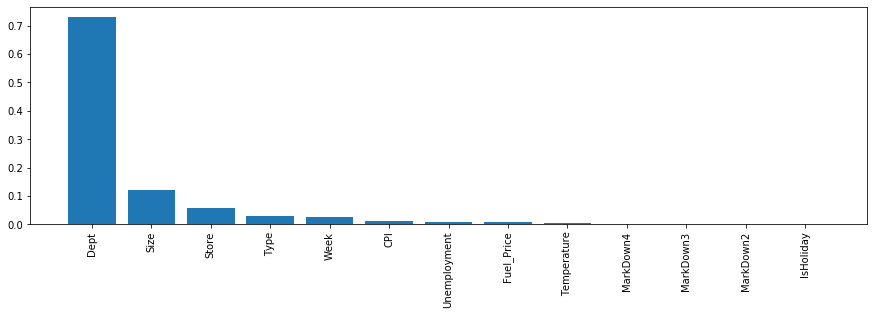

In [125]:
# Getting importance of factors
dt_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : dt.feature_importances_
                     }).sort_values(by = 'Importance', ascending=False).reset_index(drop = True)

dt_fi.to_excel(output, 'Drivers', startrow=2, startcol=5, index = False)
plt.figure(figsize=(15,4))
plt.bar(height = dt_fi.Importance, x = dt_fi.Features)
plt.xticks(rotation = 90)
plt.show()

### Predicting Test Dataset

In [126]:
Final = pd.DataFrame({
             'Id' : test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+testdate.astype(str),
             'Weekly_Sales' : np.exp(dt.predict(test[final_selected]))
                        })

Final.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,24785.077470
1,1_1_2012-11-09,19387.849102
2,1_1_2012-11-16,19387.849102
3,1_1_2012-11-23,19387.849102
4,1_1_2012-11-30,20477.500084


In [127]:
# Saving prediction on test dataset to excel
Final.to_excel('Final_Submission.xlsx', index = False)

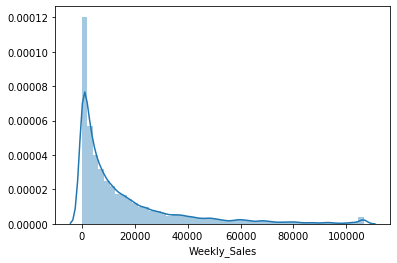

In [129]:
sns.distplot(Final.Weekly_Sales)
plt.show()

In [130]:
Final.loc[:,'deciles'] = pd.qcut(Final['Weekly_Sales'], 10, labels = False, duplicates = 'drop')

# Decile Analysis for test_output data
decile_test = Final.groupby('deciles')[['Weekly_Sales']].mean().reset_index().sort_values(by = 'deciles', ascending = False)
decile_test

,deciles,Weekly_Sales
9,9,67134.378395
8,8,33034.015694
7,7,20619.240288
6,6,13899.118604
5,5,9341.548987
4,4,6104.217805
3,3,3765.141023
2,2,2062.952391
1,1,762.790038
0,0,91.447343


In [131]:
output.save()